In [1]:
import nltk
import re
from nltk.corpus import cess_esp

In [2]:
document = "Hola, buenas tardes, quisiera un bocadillo de jamon y queso. Necesitamos 20 tartas de vainilla, ahora, es que tenemos cumpleaños hoy. Hola, si, quisieramos 8 shawarmas de pollo para esta noche. Hoy me pasare por el restaurante, tenedme listo los 2 bocadillos de tortilla que pido siempre, gracias. Hola, quisiera pedir 5 perritos calientes con mostaza para esta noche. Seria posible encargar 20 tartas de chocolate hoy?"

In [3]:
sents = cess_esp.tagged_sents()
print (sents)

[[('El', 'da0ms0'), ('grupo', 'ncms000'), ('estatal', 'aq0cs0'), ('Electricité_de_France', 'np00000'), ('-Fpa-', 'Fpa'), ('EDF', 'np00000'), ('-Fpt-', 'Fpt'), ('anunció', 'vmis3s0'), ('hoy', 'rg'), (',', 'Fc'), ('jueves', 'W'), (',', 'Fc'), ('la', 'da0fs0'), ('compra', 'ncfs000'), ('del', 'spcms'), ('51_por_ciento', 'Zp'), ('de', 'sps00'), ('la', 'da0fs0'), ('empresa', 'ncfs000'), ('mexicana', 'aq0fs0'), ('Electricidad_Águila_de_Altamira', 'np00000'), ('-Fpa-', 'Fpa'), ('EAA', 'np00000'), ('-Fpt-', 'Fpt'), (',', 'Fc'), ('creada', 'aq0fsp'), ('por', 'sps00'), ('el', 'da0ms0'), ('japonés', 'aq0ms0'), ('Mitsubishi_Corporation', 'np00000'), ('para', 'sps00'), ('poner_en_marcha', 'vmn0000'), ('una', 'di0fs0'), ('central', 'ncfs000'), ('de', 'sps00'), ('gas', 'ncms000'), ('de', 'sps00'), ('495', 'Z'), ('megavatios', 'ncmp000'), ('.', 'Fp')], [('Una', 'di0fs0'), ('portavoz', 'nccs000'), ('de', 'sps00'), ('EDF', 'np00000'), ('explicó', 'vmis3s0'), ('a', 'sps00'), ('EFE', 'np00000'), ('que', 'c

In [4]:
training = []
test = []
for i in range(len(sents)):
    if i % 10:
        training.append(sents[i])
    else:
        test.append(sents[i])

print(len(training))
print(len(test))

5427
603


In [5]:
from nltk import UnigramTagger, BigramTagger, TrigramTagger
from nltk.tag.hmm import HiddenMarkovModelTagger

hmm_tagger = HiddenMarkovModelTagger.train(training)

print ('Acierto con HMMs:', hmm_tagger.evaluate(test)*100)

Acierto con HMMs: 89.88905831011094


In [6]:
document1 = 'Hola, quiero un perrito caliente y ya está'

In [7]:
document3 = document + ' ' + document1
document3

'Hola, buenas tardes, quisiera un bocadillo de jamon y queso. Necesitamos 20 tartas de vainilla, ahora, es que tenemos cumpleaños hoy. Hola, si, quisieramos 8 shawarmas de pollo para esta noche. Hoy me pasare por el restaurante, tenedme listo los 2 bocadillos de tortilla que pido siempre, gracias. Hola, quisiera pedir 5 perritos calientes con mostaza para esta noche. Seria posible encargar 20 tartas de chocolate hoy? Hola, quiero un perrito caliente y ya está'

In [19]:
# Gramatica del chunk que nos permitira separar la informacion en cantidades, comidas e ingredientes
chunk_grammar = chunk_grammar = """Comida: {<Z|di.*>+<nc.*>+<aq.*>?}
                }<Z|di.*>+{
                Cantidad: {<Z|di.*>+}
                Ingredientes: {<sp.*><n.*><cc>?<n.*>?}
                }<sp.*>+<cc>?{""" 
    
# Creamos el parser usando nuestra gramatica chunk
regex_parser = nltk.RegexpParser(chunk_grammar)

In [20]:
from nltk import Tree

def conversion(tree):
    dlist = [] # Lista que incluira los diccionarios
    d = dict() # Diccionarios creados con las categorias creadas con nuestra gramatica chunk
    for item in tree:
        if isinstance(item, Tree): # Si tenemos un arbol creamos un diccionario que contenga las hojas
            d[item.label()] = ' '.join([l[0] for l in item.leaves()])
        else:
            dlist.append(d) if len(d)>0 else None # Cuando acabamos devolvemos el diccionario
            d = dict()
    dlist.append(d) if len(d)>0 else None # anadimos los diccionarios en la lista hasta el finl
    return dlist

def process_order(document):
    '''Esta funcion comprueba de si se trata de un solo pedido o de varios, despues procesa la informacion
    para sacar cantidades, comidas e ingredientes'''
    
    # Esta comprehension list nos dira si se trata de multiples pedidos o si se trata de uno solo
    sentences = [sent for sent in nltk.sent_tokenize(document)]
    
    if len(sentences) > 1: # Se trata de un pedido multiple
        
        # Parseamos nuestro texto usando nuestro regex_parser
        parsed_text = [regex_parser.parse(hmm_tagger.tag(nltk.word_tokenize(sent))) for sent in nltk.sent_tokenize(document)]

    
        # Este bucle for introduce los diccionarios en una lista
        info = []
        for tree in parsed_text:
            info.append(conversion(tree)) 
        
        # Este bucle for une los diccionario de comida y cantidad con el de ingredientes, y desecha el duplicado ingredientes
        for i in range(len(info)):
        # Los ingredientes aparecen en una diccionario diferente por lo que este 'if' maneja la excepcion de que no haya ingredientes
            if len(info[i]) > 1:
                info[i][0].update(info[i][1])
                info[i].pop()
        
        # Este bucle for desempaqueta los diccionarios de dentro de las listas.    
        list_dictionaries = []
        for i in range(len(info)):
            list_dictionaries.append(info[i][0])
        return list_dictionaries
    
    else: # Se trata de un solo pedido
        parsed_text = [regex_parser.parse(hmm_tagger.tag(nltk.word_tokenize(document)))]
        info = []
        for tree in parsed_text:
            info.append(conversion(tree)) 
        if len(info[0]) > 1:
            info[0][0].update(info[0][1])
            info[0].pop()
        return info[0][0]

In [21]:
process_order(document1)

{'Cantidad': 'un', 'Comida': 'perrito caliente'}

In [22]:
process_order(document3)

[{'Cantidad': 'un', 'Comida': 'bocadillo', 'Ingredientes': 'jamon y queso'},
 {'Cantidad': '20', 'Comida': 'tartas', 'Ingredientes': 'vainilla'},
 {'Cantidad': '8', 'Comida': 'shawarmas', 'Ingredientes': 'pollo'},
 {'Cantidad': '2', 'Comida': 'bocadillos', 'Ingredientes': 'tortilla'},
 {'Cantidad': '5', 'Comida': 'perritos calientes', 'Ingredientes': 'mostaza'},
 {'Cantidad': '20', 'Comida': 'tartas', 'Ingredientes': 'chocolate'},
 {'Cantidad': 'un', 'Comida': 'perrito caliente'}]

In [16]:
def process_iob_tags(document):
    '''Esta funcion comprueba de si se trata de un solo pedido o de varios, despues procesa la informacion
    para sacar cantidades, comidas e ingredientes'''
    
    # Esta comprehension list nos dira si se trata de multiples pedidos o si se trata de uno solo
    sentences = [sent for sent in nltk.sent_tokenize(document)]
    
    if len(sentences) > 1: # Se trata de un pedido multiple
        
        # Parseamos nuestro texto usando nuestro regex_parser
        parsed_text = [regex_parser.parse(hmm_tagger.tag(nltk.word_tokenize(sent))) for sent in nltk.sent_tokenize(document)]

    
        # Este bucle for introduce los diccionarios en una lista
        for parsed_sent in parsed_text:
            list_of_lists = []
            for i in range(len(parsed_text)):
                # Filtramos el arbol padre S
                for j in parsed_text[i].subtrees(filter = lambda x: x.label() == 'S'):
                    # Obtenemos las etiquetas
                    iob_tags = nltk.tree2conlltags(j)
    
                    words_tagged = []
    
                    for iob in iob_tags: 
                        words_tagged.append(iob)
                list_of_lists.append(words_tagged)

        return list_of_lists
    
    else: # Se trata de un solo pedido
        parsed_text1 = [regex_parser.parse(hmm_tagger.tag(nltk.word_tokenize(sent))) for sent in nltk.sent_tokenize(document)]
        list_of_lists1 = []
        for i in parsed_text1[0].subtrees(filter = lambda x: x.label() == 'S'):
            iob_tags = nltk.tree2conlltags(i)
    
            words_tagged = []
    
            for iob in iob_tags: 
                words_tagged.append(iob)
                
            list_of_lists1.append(words_tagged)
            
            return(list_of_lists1)

In [17]:
process_iob_tags(document1)

[[('Hola', 'np0000p', 'O'),
  (',', 'Fc', 'O'),
  ('quiero', 'vmis3s0', 'O'),
  ('un', 'di0ms0', 'B-Cantidad'),
  ('perrito', 'ncms000', 'B-Comida'),
  ('caliente', 'aq0cs0', 'I-Comida'),
  ('y', 'cc', 'O'),
  ('ya', 'rg', 'O'),
  ('está', 'vmip3s0', 'O')]]

In [18]:
process_iob_tags(document3)

[[('Hola', 'np0000p', 'O'),
  (',', 'Fc', 'O'),
  ('buenas', 'aq0fp0', 'O'),
  ('tardes', 'ncfp000', 'O'),
  (',', 'Fc', 'O'),
  ('quisiera', 'vmis3s0', 'O'),
  ('un', 'di0ms0', 'B-Cantidad'),
  ('bocadillo', 'ncms000', 'B-Comida'),
  ('de', 'sps00', 'O'),
  ('jamon', 'np0000l', 'B-Ingredientes'),
  ('y', 'cc', 'I-Ingredientes'),
  ('queso', 'np0000p', 'I-Ingredientes'),
  ('.', 'Fp', 'O')],
 [('Necesitamos', 'da0mp0', 'O'),
  ('20', 'Z', 'B-Cantidad'),
  ('tartas', 'ncmp000', 'B-Comida'),
  ('de', 'sps00', 'O'),
  ('vainilla', 'np0000l', 'B-Ingredientes'),
  (',', 'Fc', 'O'),
  ('ahora', 'rg', 'O'),
  (',', 'Fc', 'O'),
  ('es', 'vsip3s0', 'O'),
  ('que', 'cs', 'O'),
  ('tenemos', 'sn.e-SUJ', 'O'),
  ('cumpleaños', 'vmis3s0', 'O'),
  ('hoy', 'rg', 'O'),
  ('.', 'Fp', 'O')],
 [('Hola', 'np0000p', 'O'),
  (',', 'Fc', 'O'),
  ('si', 'cs', 'O'),
  (',', 'Fc', 'O'),
  ('quisieramos', 'sps00', 'O'),
  ('8', 'Z', 'B-Cantidad'),
  ('shawarmas', 'ncmp000', 'B-Comida'),
  ('de', 'sps00', 'O'),
 

In [23]:
def create_trees(document):
    
    sentences = [sent for sent in nltk.sent_tokenize(document)]

    chunks = []

    for sentence in sentences:
        sentence_tokens = nltk.word_tokenize(sentence)
        tagged_sentence = hmm_tagger.tag(sentence_tokens)
        tree = regex_parser.parse(tagged_sentence)
        #añadimos el árbol directamente ya que los taggers entrenan con árboles con los chunks etiquetados
        chunks.append(tree)
    return chunks

In [26]:
create_trees(document3)

[Tree('S', [('Hola', 'np0000p'), (',', 'Fc'), ('buenas', 'aq0fp0'), ('tardes', 'ncfp000'), (',', 'Fc'), ('quisiera', 'vmis3s0'), Tree('Cantidad', [('un', 'di0ms0')]), Tree('Comida', [('bocadillo', 'ncms000')]), ('de', 'sps00'), Tree('Ingredientes', [('jamon', 'np0000l'), ('y', 'cc'), ('queso', 'np0000p')]), ('.', 'Fp')]),
 Tree('S', [('Necesitamos', 'da0mp0'), Tree('Cantidad', [('20', 'Z')]), Tree('Comida', [('tartas', 'ncmp000')]), ('de', 'sps00'), Tree('Ingredientes', [('vainilla', 'np0000l')]), (',', 'Fc'), ('ahora', 'rg'), (',', 'Fc'), ('es', 'vsip3s0'), ('que', 'cs'), ('tenemos', 'sn.e-SUJ'), ('cumpleaños', 'vmis3s0'), ('hoy', 'rg'), ('.', 'Fp')]),
 Tree('S', [('Hola', 'np0000p'), (',', 'Fc'), ('si', 'cs'), (',', 'Fc'), ('quisieramos', 'sps00'), Tree('Cantidad', [('8', 'Z')]), Tree('Comida', [('shawarmas', 'ncmp000')]), ('de', 'sps00'), Tree('Ingredientes', [('pollo', 'ncms000')]), ('para', 'sps00'), ('esta', 'dd0fs0'), ('noche', 'ncfs000'), ('.', 'Fp')]),
 Tree('S', [('Hoy', 'rg'

In [27]:
trees = create_trees(document3)

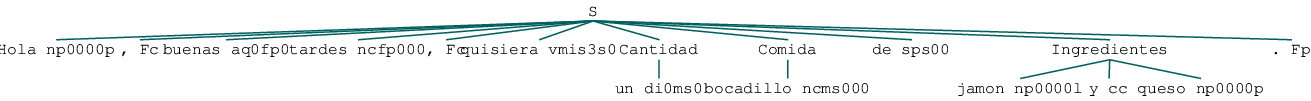

In [28]:
trees[0]

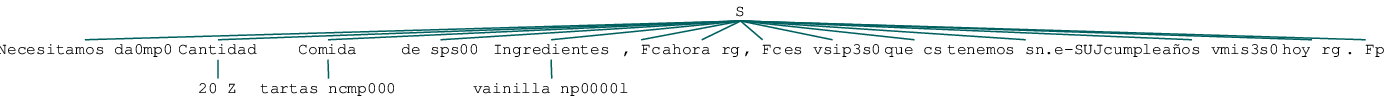

In [29]:
trees[1]

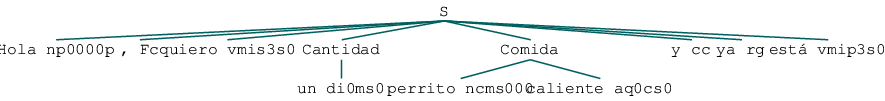

In [30]:
trees[6]